In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
from scipy.signal import argrelextrema

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2
module = '/home/dalessandro/module_script/qe_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'pre_processing': '/home/dalessandro/module_script/qe_module',
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [5]:
# RunRules for m100
nodes = 1
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',
                memory='120GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.QeCalculator(rr)
#code.global_options()

# DFT analysis of the AGSL5

This notebook contains the DFT analysis of the Armchair Graphene SuperLattice with 5 C atoms between each H atom along the Y (armchair) direction performed with QuantumESPRESSO

## Lattice properties and atomic positions

We extract the atomic positions and lattice properties from the starting input file provided by Vasil

In [78]:
inp = I.PwInput(file='Input_Vasil/qe_scf.in')
atoms = inp['atomic_positions']['values'] # provided in angstrom
cell_parameters = inp['cell_parameters']['values'] # provided in angstrom

In [79]:
atoms,cell_parameters

([['C', [-1.792510823, 1.4456517994, -0.0414672295]],
  ['C', [0.6379373039, 1.4235971792, -0.3172245562]],
  ['C', [3.0657768079, 1.4455042995, -0.0157591793]],
  ['C', [-0.5959562906, 0.7133098684, -0.2503074405]],
  ['C', [1.8700368141, 0.7135148531, -0.2270262819]],
  ['C', [-3.0402753064, -0.7719313527, 0.4823609916]],
  ['H', [-3.0239104491, -1.0594331893, 1.5579425823]],
  ['C', [-0.5959562909, -0.7133098686, -0.2503074405]],
  ['C', [1.8700368138, -0.7135148525, -0.2270262819]],
  ['C', [-1.7925108232, -1.4456518, -0.0414672295]],
  ['C', [0.6379373034, -1.423597179, -0.3172245562]],
  ['C', [3.0657768077, -1.4455042985, -0.0157591793]],
  ['C', [-3.040275306, 0.7719313517, 0.4823609916]],
  ['H', [-3.0239104484, 1.0594331883, 1.5579425823]]],
 [[7.363588492, 1e-06, 0.0], [1e-09, 4.272655813, 0.0], [0.0, 0.0, 12.0]])

In [80]:
positions = LL.build_lattice(lattice,atoms,3,4,1)

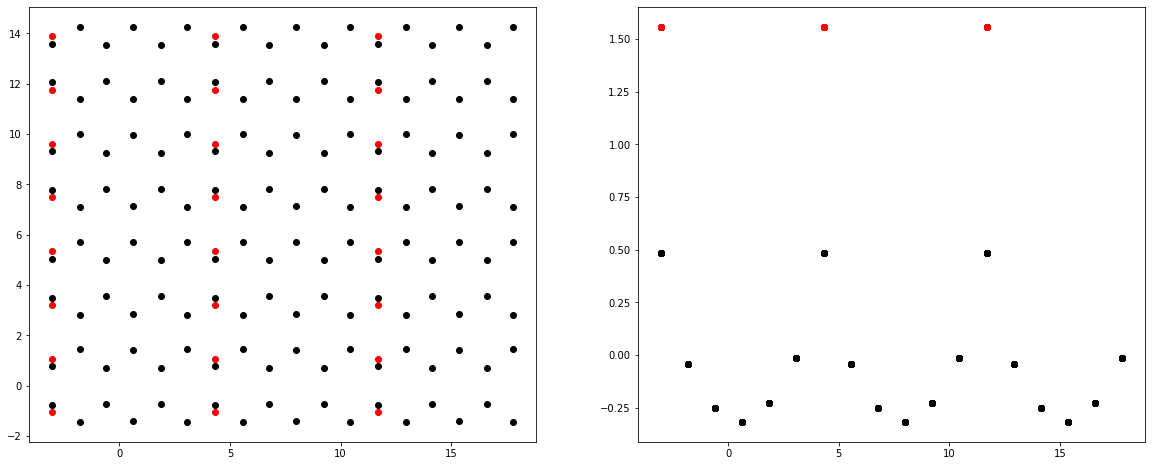

In [81]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[0].scatter(at[1],at[2],color=color)
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[1].scatter(at[1],at[3],color=color)


## GS analysis

In [91]:
run_dir = 'DFT_analysis'

We use the input file 'Input_Vasil/qe_scf.in' as starting point for the DFT analysis

In [89]:
inp = I.PwInput(file='Input_Vasil/qe_scf.in')
inp.set_scf(force_symmorphic=True,conv_thr=1e-7)
inp.set_pseudo_dir('../pseudos')
inp.add_atom(atom='C',pseudo_name='C_ONCV_PBE.upf',mass=12.011)
inp.add_atom(atom='H',pseudo_name='H_ONCV_PBE.upf',mass=1.0)
inp.set_num_bnds(26)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.false.',
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 0,
  'nat': 14,
  'ntyp': 2,
  'ecutwfc': 70,
  'nbnd': 26,
  'occupations': "'fixed'",
  'degauss': 0.0,
  'smearing': "'gaussian'"},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-07},
 'ions': {},
 'cell': {},
 'atomic_species': {'C': [12.011, 'C_ONCV_PBE.upf'],
  'H': [1.0, 'H_ONCV_PBE.upf']},
 'atomic_positions': {'type': '(angstrom)',
  'values': [['C', [-1.792510823, 1.4456517994, -0.0414672295]],
   ['C', [0.6379373039, 1.4235971792, -0.3172245562]],
   ['C', [3.0657768079, 1.4455042995, -0.0157591793]],
   ['C', [-0.5959562906, 0.7133098684, -0.2503074405]],
   ['C', [1.8700368141, 0.7135148531, -0.2270262819]],
   ['C', [-3.0402753064, -0.7719313527, 0.4823609916]],
   ['H', [-3.0239104491, -1.0594331893, 1.5579425

In [92]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [95]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
create the run_dir folder : 'DFT_analysis'
run command: mpirun -np 16 pw.x -inp gs_converged.in > gs_converged.log
slurm submit:  cd DFT_analysis ; sbatch job_gs_converged.sh
computation gs_converged is running...
computation gs_converged ended
Task [0] ended 
 


In [96]:
results[0].get_gap()

Direct gap system
Gap : 0.3000691889660106 eV


{'gap': 0.3000691889660106,
 'direct_gap': 0.3000691889660106,
 'position_cbm': 0,
 'position_vbm': 0,
 'position_direct_gap': 0}

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b or the crystal_b type of
pw) and we make usage of the function build_kpath

In [157]:
bands_prefix = 'bands'

# cryst  coords
G_cryst = [0.0,0.0,0.0]
M2_cryst = [0.0,0.5,0.0]
K_cryst = [0.5,0.5,0.0]
M_cryst = [0.5,0.0,0.0]

# cartesian  coords
G = [0.0,0.0,0.0]
M2 = [0.0,0.8617109,0.0]
K = [0.5,0.8617109,0.0]
M = [0.5,0.0,0.0]

high_sym = {'G':G,'K':K,'M':M,'M2':M2} # useful to label the high-sym point on the path

In [158]:
klist = Tools.build_pw_kpath(G,M2,K,M,G,K,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 0.8617109, 0.0, 30],
 [0.5, 0.8617109, 0.0, 30],
 [0.5, 0.0, 0.0, 30],
 [0.0, 0.0, 0.0, 30],
 [0.5, 0.8617109, 0.0, 0]]

In [160]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-7)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist) #crystal_b
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.false.',
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 0,
  'nat': 14,
  'ntyp': 2,
  'ecutwfc': 70,
  'nbnd': 30,
  'occupations': "'fixed'",
  'degauss': 0.0,
  'smearing': "'gaussian'"},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-07},
 'ions': {},
 'cell': {},
 'atomic_species': {'C': [12.011, 'C_ONCV_PBE.upf'],
  'H': [1.0, 'H_ONCV_PBE.upf']},
 'atomic_positions': {'type': '(angstrom)',
  'values': [['C', [-1.792510823, 1.4456517994, -0.0414672295]],
   ['C', [0.6379373039, 1.4235971792, -0.3172245562]],
   ['C', [3.0657768079, 1.4455042995, -0.0157591793]],
   ['C', [-0.5959562906, 0.7133098684, -0.2503074405]],
   ['C', [1.8700368141, 0.7135148531, -0.2270262819]],
   ['C', [-3.0402753064, -0.7719313527, 0.4823609916]],
   ['H', [-3.0239104491, -1.0594331893, 1.55794

In [161]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged.save',skip=False)

delete job_out script: DFT_analysis/job_bands.out
delete log file: DFT_analysis/bands.log
delete xml file: /work/dalessandro/Xenes/AGSL5/DFT_analysis/bands.xml
delete folder: /work/dalessandro/Xenes/AGSL5/DFT_analysis/bands.save
copy source_dir DFT_analysis/gs_converged.save in the /work/dalessandro/Xenes/AGSL5/DFT_analysis/bands.save
run command: mpirun -np 16 pw.x -inp bands.in > bands.log
slurm submit:  cd DFT_analysis ; sbatch job_bands.sh
computation bands is running...
computation bands ended


Once that the computation is over we can create an instance of PwBands

In [162]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [163]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'K', 'M', 'M2'],
 [0.0,
  2.723421799999997,
  1.361710899999999,
  3.7196876657099534,
  2.223421799999999,
  0.8617109])

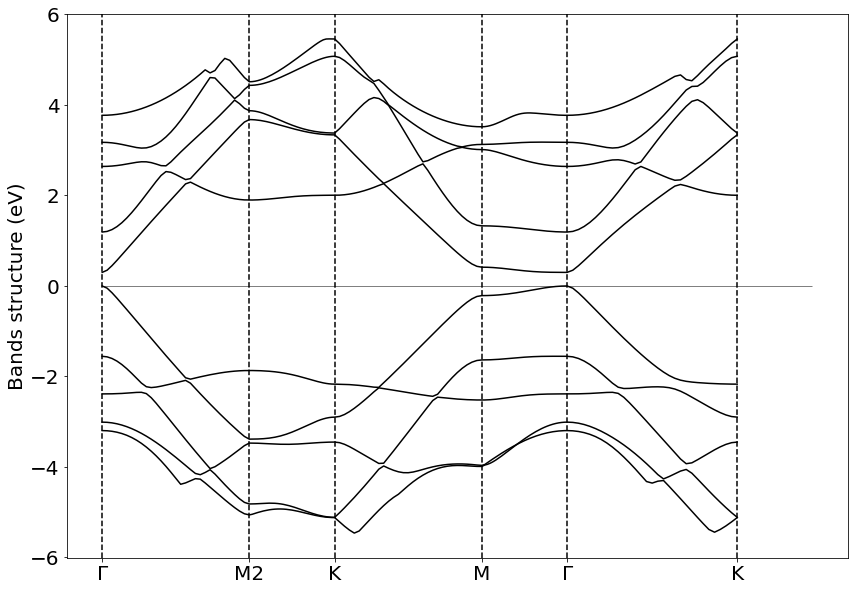

In [164]:
label_size = 20

fig, ax = plt.subplots(figsize=(14, 10))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,30)],color='black') #
#bands.plot(plt,selection=[i for i in range(26,30)],color='red')
ax.hlines(0.,0.,4.16,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

The result seems to be in good agreement with the one of Vasil.

## NSCF computations on regular grids

We set up the nscf computations on regular grids.

In agreement with the strategy adopted by Vasil we test k-point samplings of the type $k\times 2k\times 1$.

First we set the number of bands to 35, in this way we can perform the GW converge at the HF level and we can also
compute the IP absorption spectrum testing its convergence in terms of the k-points samplings.

In [166]:
# cartesian  coords
G = np.array([0.0,0.0])
M2 = np.array([0.0,0.8617109])
K = np.array([0.5,0.8617109])
M = np.array([0.5,0.0])

In [167]:
nbnds = 35
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
#inp

In [168]:
kvalues = [10,20]

In [169]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':'%sx%s'%(k,2*k),'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,2*k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis/gs_converged.save')

Initialize a Dataset with 2 parallel tasks


In [170]:
#study.runs[0]

In [171]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
Skip the run of kpoints_10x20-nbnds_35
The folder /work/dalessandro/Xenes/AGSL5/DFT_analysis/kpoints_10x20-nbnds_35.save already exists. Source_dir DFT_analysis/gs_converged.save not copiedSkip the run of
 kpoints_20x40-nbnds_35
The folder /work/dalessandro/Xenes/AGSL5/DFT_analysis/kpoints_20x40-nbnds_35.save already exists. Source_dir DFT_analysis/gs_converged.save not copied
Task [0, 1] ended 
 


In [175]:
kp = results[1].kpoints # cartesian coordinates in units of 2\pi/alat

number of kpoints = 231


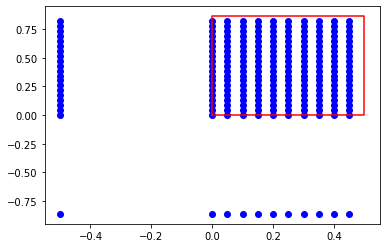

In [176]:
#BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
#plt.plot(*np.column_stack(BZ),color='black')
IBZ = [G,M2,K,M,G]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')